### System Analysis
This notebook contains the analysis functions to calculate steady state error for each controller architecture.
Plotting functions are included to support analysis.

Import Controller ODE Solutions

In [13]:
import import_ipynb
from direct_closed_loop import dcl_solution
# from direct_open_loop import dol_solution
# from indirect_closed_loop import icl_solution
# from indirect_open_loop import iol_solution
from kinetic_parameters import to_latex_label

In [10]:
def calculate_SSE(solution):
    '''
    the solution is a pandas dataframe with the columns 
    time[s], X, Y, A, P_Y+, O

    X is the reference
    O is the output
    '''
    error = solution["X"] - solution["O"]
    SSE = error.iloc[-1]
    return SSE

def plot_solution(ax, solution):
    time_hrs = solution["time[s]"] / 3600
    for column in solution:
        if column != "time[s]":
            ax.plot(time_hrs, solution[column], label=to_latex_label(column))
    ax.set_xlabel("Time [hr]")
    ax.set_ylabel("Species Concentration [nm]")
    return ax.figure, ax

def plot_input_output(ax, solution):
    time_hrs = solution["time[s]"] / 3600
    ax.plot(time_hrs, solution["O"], label="Output", marker = "o", markersize=10, fillstyle="none", color = "teal")
    ax.plot(time_hrs, solution["X"], label="Reference", linestyle = "--", linewidth = 3, color = "gray")
    ax.set_xlabel("Time [hr]")
    ax.set_ylabel("Species Concentration [nM]")
    return ax.figure, ax

def get_fig2a_data(controller_func):
    P_X = [0, 6, 12, 18, 24, 30] # [nM]
    P_Y = 20 # [nM]

    steady_state_values = []
    for ic in P_X:
        solution = controller_func(ic)
        steady_state_values.append(solution.iloc[-1])
    return P_X, steady_state_values


def get_fig2b_data(controller_func):
    P_X = [0, 6, 12, 18, 24, 30] # [nM]
    P_Y = 20 # [nM]

    steady_state_errors = []
    for ic in P_X:
        solution = controller_func(ic)
        steady_state_errors.append(calculate_SSE(solution))
    return P_X, steady_state_errors

def plot_fig2a(ax, fig2a_data):
    P_X, steady_state_values = fig2a_data

    output = [ss_value["O"] for ss_value in steady_state_values]
    reference = [ss_value["X"] for ss_value in steady_state_values]

    ax.plot(P_X, output, label="Output",  marker = "o", markersize=10, fillstyle="none", color = "teal")
    ax.plot(P_X, reference, label="Reference", linestyle = "--", linewidth = 3, color = "gray")

    ax.set_xlabel(to_latex_label("P_X")  + " [nM]")
    ax.set_ylabel("Species Concentration [nM]")
    return ax.figure, ax

def plot_fig2b(ax, fig2b_data):
    P_X, steady_state_errors = fig2b_data

    ax.plot(P_X, steady_state_errors, label="SSE",  marker = "o", markersize=10, fillstyle="none", color = "teal")

    ax.set_xlabel(to_latex_label("P_X")  + " [nM]")
    ax.set_ylabel("Steady State Error [nM]")
    return ax.figure, ax
    return

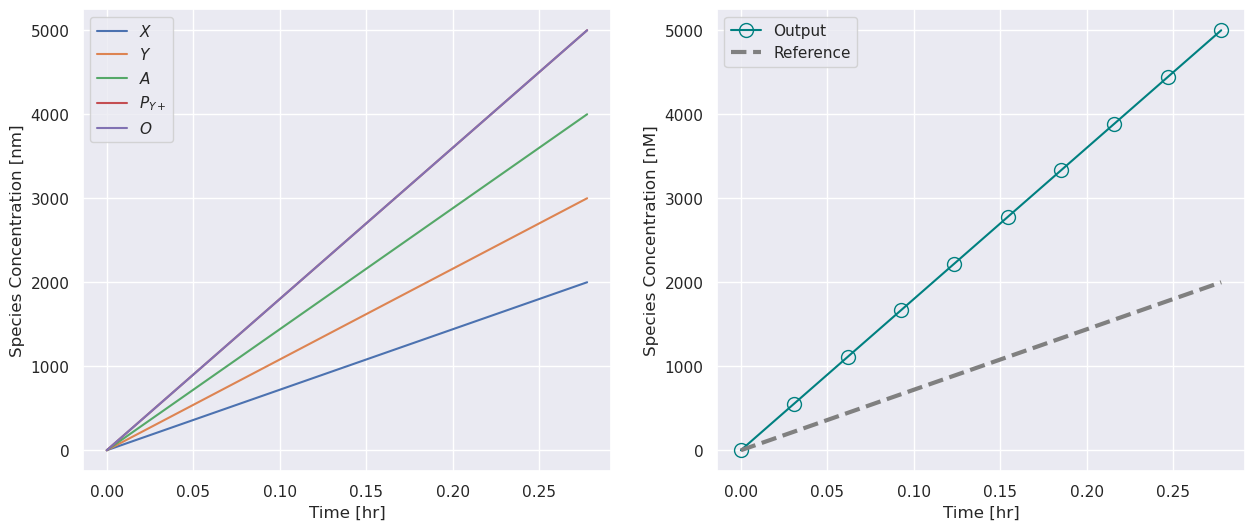

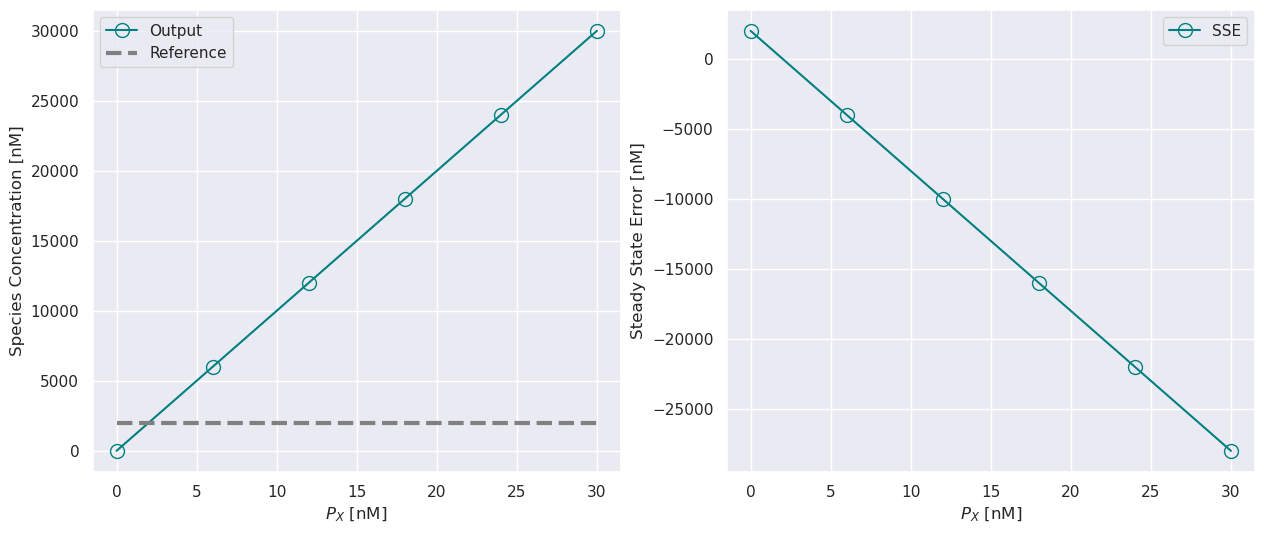

In [12]:
import matplotlib.pyplot as plt


# Figure 1 e-f
fig, axs = plt.subplots(1,2, figsize=(15,6))
fig, axs[0] = plot_solution(axs[0], dcl_solution())
fig, axs[1] = plot_input_output(axs[1], dcl_solution())

for ax in axs.flatten():
    ax.legend()


# Figure 2a-b
fig2a_data = get_fig2a_data(dcl_solution)
fig2b_data = get_fig2b_data(dcl_solution)

fig, axs = plt.subplots(1,2, figsize=(15,6))
fig, axs[0] =  plot_fig2a(axs[0], fig2a_data)
fig, axs[1] =  plot_fig2b(axs[1], fig2b_data)


for ax in axs.flatten():
    ax.legend()
